In [47]:
import numpy as np
import random
import matplotlib.pyplot as plt # Graphical library
from sklearn.metrics import mean_squared_error # Mean-squared error function
import sys
import itertools

In [48]:
# WARNING: fill in these two functions that will be used by the auto-marking script
# [Action required]

def get_CID():
  return "02451677" # Return your CID (add 0 at the beginning to ensure it is 8 digits long)

def get_login():
  return "Mg423" # Return your short imperial login

## Helper Class

In [49]:
# This class is used ONLY for graphics
# YOU DO NOT NEED to understand it to work on this coursework

class GraphicsMaze(object):

  def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):

    self.shape = shape
    self.locations = locations
    self.absorbing = absorbing

    # Walls
    self.walls = np.zeros(self.shape)
    for ob in obstacle_locs:
      self.walls[ob] = 20

    # Rewards
    self.rewarders = np.ones(self.shape) * default_reward
    for i, rew in enumerate(absorbing_locs):
      self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

    # Print the map to show it
    self.paint_maps()

  def paint_maps(self):
    """
    Print the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders)
    plt.show()

  def paint_state(self, state):
    """
    Print one state on the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    states = np.zeros(self.shape)
    states[state] = 30
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders + states)
    plt.show()

  def draw_deterministic_policy(self, Policy):
    """
    Draw a deterministic policy
    input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, action in enumerate(Policy):
      if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
        continue
      arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
      action_arrow = arrows[action] # Take the corresponding action
      location = self.locations[state] # Compute its location on graph
      plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    plt.show()

  def draw_policy(self, Policy):
    """
    Draw a policy (draw an arrow in the most probable direction)
    input: Policy {np.array} -- policy to draw as probability
    output: /
    """
    deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
    self.draw_deterministic_policy(deterministic_policy)

  def draw_value(self, Value):
    """
    Draw a policy value
    input: Value {np.array} -- policy values to draw
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, value in enumerate(Value):
      if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
        continue
      location = self.locations[state] # Compute the value location on graph
      plt.text(location[1], location[0], np.round(value,2), ha='center', va='center') # Place it on graph
    plt.show()

  def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple deterministic policies
    input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Policies)): # Go through all policies
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, action in enumerate(Policies[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
          continue
        arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
        action_arrow = arrows[action] # Take the corresponding action
        location = self.locations[state] # Compute its location on graph
        plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
    plt.show()

  def draw_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policies (draw an arrow in the most probable direction)
    input: Policy {np.array} -- array of policies to draw as probability
    output: /
    """
    deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
    self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

  def draw_value_grid(self, Values, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policy values
    input: Values {np.array of np.array} -- array of policy values to draw
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Values)): # Go through all values
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, value in enumerate(Values[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
          continue
        location = self.locations[state] # Compute the value location on graph
        plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
    plt.show()


## Maze Class

In [50]:
# This class define the Maze environment

class Maze(object):

  # [Action required]
  def __init__(self):
    """
    Maze initialisation.
    input: /
    output: /
    """

    # [Action required]
    # Properties set from the CID
    self._prob_success = 0.84 # float
    self._gamma = 0.9 # float
    self._goal = 3 # integer (0 for R0, 1 for R1, 2 for R2, 3 for R3)

    # Build the maze
    self._build_maze()

  # Functions used to build the Maze environment
  # You DO NOT NEED to modify them
  def _build_maze(self):
    """
    Maze initialisation.
    input: /
    output: /
    """

    # Properties of the maze
    self._shape = (13, 10)
    self._obstacle_locs = [
                          (1,0), (1,1), (1,2), (1,3), (1,4), (1,7), (1,8), (1,9), \
                          (2,1), (2,2), (2,3), (2,7), \
                          (3,1), (3,2), (3,3), (3,7), \
                          (4,1), (4,7), \
                          (5,1), (5,7), \
                          (6,5), (6,6), (6,7), \
                          (8,0), \
                          (9,0), (9,1), (9,2), (9,6), (9,7), (9,8), (9,9), \
                          (10,0)
                         ] # Location of obstacles
    self._absorbing_locs = [(2,0), (2,9), (10,1), (12,9)] # Location of absorbing states
    self._absorbing_rewards = [ (500 if (i == self._goal) else -50) for i in range (4) ]
    self._starting_locs = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)] #Reward of absorbing states
    self._default_reward = -1 # Reward for each action performs in the environment
    self._max_t = 500 # Max number of steps in the environment

    # Actions
    self._action_size = 4
    self._direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on

    # States
    self._locations = []
    for i in range (self._shape[0]):
      for j in range (self._shape[1]):
        loc = (i,j)
        # Adding the state to locations if it is no obstacle
        if self._is_location(loc):
          self._locations.append(loc)
    self._state_size = len(self._locations)

    # Neighbours - each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
    self._neighbours = np.zeros((self._state_size, 4))

    for state in range(self._state_size):
      loc = self._get_loc_from_state(state)

      # North
      neighbour = (loc[0]-1, loc[1]) # North neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('N')] = state

      # East
      neighbour = (loc[0], loc[1]+1) # East neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('E')] = state

      # South
      neighbour = (loc[0]+1, loc[1]) # South neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('S')] = state

      # West
      neighbour = (loc[0], loc[1]-1) # West neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('W')] = state

    # Absorbing
    self._absorbing = np.zeros((1, self._state_size))
    for a in self._absorbing_locs:
      absorbing_state = self._get_state_from_loc(a)
      self._absorbing[0, absorbing_state] = 1

    # Transition matrix
    self._T = np.zeros((self._state_size, self._state_size, self._action_size)) # Empty matrix of domension S*S*A
    for action in range(self._action_size):
      for outcome in range(4): # For each direction (N, E, S, W)
        # The agent has prob_success probability to go in the correct direction
        if action == outcome:
          prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0) # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
        # Equal probability to go into one of the other directions
        else:
          prob = (1.0 - self._prob_success) / 3.0

        # Write this probability in the transition matrix
        for prior_state in range(self._state_size):
          # If absorbing state, probability of 0 to go to any other states
          if not self._absorbing[0, prior_state]:
            post_state = self._neighbours[prior_state, outcome] # Post state number
            post_state = int(post_state) # Transform in integer to avoid error
            self._T[prior_state, post_state, action] += prob

    # Reward matrix
    self._R = np.ones((self._state_size, self._state_size, self._action_size)) # Matrix filled with 1
    self._R = self._default_reward * self._R # Set default_reward everywhere
    for i in range(len(self._absorbing_rewards)): # Set absorbing states rewards
      post_state = self._get_state_from_loc(self._absorbing_locs[i])
      self._R[:,post_state,:] = self._absorbing_rewards[i]

    # Creating the graphical Maze world
    self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)

    # Reset the environment
    self.reset()


  def _is_location(self, loc):
    """
    Is the location a valid state (not out of Maze and not an obstacle)
    input: loc {tuple} -- location of the state
    output: _ {bool} -- is the location a valid state
    """
    if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0]-1 or loc[1] > self._shape[1]-1):
      return False
    elif (loc in self._obstacle_locs):
      return False
    else:
      return True


  def _get_state_from_loc(self, loc):
    """
    Get the state number corresponding to a given location
    input: loc {tuple} -- location of the state
    output: index {int} -- corresponding state number
    """
    return self._locations.index(tuple(loc))


  def _get_loc_from_state(self, state):
    """
    Get the state number corresponding to a given location
    input: index {int} -- state number
    output: loc {tuple} -- corresponding location
    """
    return self._locations[state]

  # Getter functions used only for DP agents
  # You DO NOT NEED to modify them
  def get_T(self):
    return self._T

  def get_R(self):
    return self._R

  def get_absorbing(self):
    return self._absorbing

  # Getter functions used for DP, MC and TD agents
  # You DO NOT NEED to modify them
  def get_graphics(self):
    return self._graphics

  def get_action_size(self):
    return self._action_size

  def get_state_size(self):
    return self._state_size

  def get_gamma(self):
    return self._gamma

  # Functions used to perform episodes in the Maze environment
  def reset(self):
    """
    Reset the environment state to one of the possible starting states
    input: /
    output:
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """
    self._t = 0
    self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
    self._reward = 0
    self._done = False
    return self._t, self._state, self._reward, self._done

  def step(self, action):
    """
    Perform an action in the environment
    input: action {int} -- action to perform
    output:
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """

    # If environment already finished, print an error
    if self._done or self._absorbing[0, self._state]:
      print("Please reset the environment")
      return self._t, self._state, self._reward, self._done

    # Drawing a random number used for probaility of next state
    probability_success = random.uniform(0,1)

    # Look for the first possible next states (so get a reachable state even if probability_success = 0)
    new_state = 0
    while self._T[self._state, new_state, action] == 0:
      new_state += 1
    assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

    # Find the first state for which probability of occurence matches the random value
    total_probability = self._T[self._state, new_state, action]
    while (total_probability < probability_success) and (new_state < self._state_size-1):
     new_state += 1
     total_probability += self._T[self._state, new_state, action]
    assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."

    # Setting new t, state, reward and done
    self._t += 1
    self._reward = self._R[self._state, new_state, action]
    self._done = self._absorbing[0, new_state] or self._t > self._max_t
    self._state = new_state
    return self._t, self._state, self._reward, self._done

## DP Agent

In [60]:
# This class define the Dynamic Programing agent
# [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
"""
    Solve a given Maze environment using Dynamic Programming
    input: env {Maze object} -- Maze to solve
    output:
      - policy {np.array} -- Optimal policy found to solve the given Maze environment
      - V {np.array} -- Corresponding value function
    """
class DP_agent(object):
    
     def solve(self,env, gamma=0.9, threshold=0.0001):
            # Initialize policy and value function
            policy = np.zeros((env.get_state_size(), env.get_action_size()))
            V = np.zeros(env.get_state_size())
            # Ensure gamma value is within a valid range
            assert (gamma <= 1) and (gamma >= 0), "Discount factor should be in [0, 1]."
            # Initialize variables for the main loop
            epochs = 0
            delta = threshold  # Setting a value for delta to go through the first breaking condition
            while delta >= threshold:
                epochs += 1  # Increment the epoch
                delta = 0  # Reinitialize delta value
                # For each state
                for prior_state in range(env.get_state_size()):
                    # If not an absorbing state
                    if not env.get_absorbing()[0, prior_state]:
                        # Store the previous value for that state
                        v = V[prior_state]
                        # Compute Q value
                        Q = np.zeros(4)  # Initialize with value 0
                        for post_state in range(env.get_state_size()):
                            Q += env.get_T()[prior_state, post_state, :] * (env.get_R()[prior_state, post_state, :] + gamma * V[post_state])
                
                        # Set the new value to the maximum of Q
                        V[prior_state] = np.max(Q)
                        # Compute the new delta
                        delta = max(delta, np.abs(v - V[prior_state])
            # When the loop is finished, fill in the optimal policy
            policy = np.zeros((env.get_state_size(), env.get_action_size()))  # Initialization
            for prior_state in range(env.get_state_size()):
                                    # Compute the Q value
                                    Q = np.zeros(4)
                                    for post_state in range(env.get_state_size()):
                                    Q += env.get_T()[prior_state, post_state, :] * (env.get_R()[prior_state, post_state, :] + gamma * V[post_state])
                                    # The action that maximizes the Q value gets probability 1
                                     policy[prior_state, np.argmax(Q)] = 1
    
            return policy, V, epochs

SyntaxError: invalid syntax (<ipython-input-60-83616b610516>, line 41)

## MC Agent

In [37]:
# This class define the Monte-Carlo agent

class MC_agent(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
    """
    Solve a given Maze environment using Monte Carlo learning
    input: env {Maze object} -- Maze to solve
    output:
      - policy {np.array} -- Optimal policy found to solve the given Maze environment
      - values {list of np.array} -- List of successive value functions for each episode
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode
    """

    # Initialisation (can be edited)
    ####
    # Add your code here
    # WARNING: this agent only has access to env.reset() and env.step()
    # You should not use env.get_T(), env.get_R() or env.get_absorbing() to compute any value
    ####

    #the code is implemented using 1st visit Monte Carlo Predictions with Control
    def __init__(self, env, epsilon, learning_rate, episodes):
        self.env = env
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.episodes = episodes
        self.state_size = env.get_state_size()
        self.action_size = env.get_action_size()
        self.Q = np.zeros((self.state_size, self.action_size))
        self.policy = np.ones((self.state_size, self.action_size)) / self.action_size  # Initialize policy as a uniform distribution
        self.total_rewards = []
        self.gamma=env.get_gamma()
    
    def epsilon_greedy(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.env.get_action_size() - 1)  # Exploration
        else:
            return np.argmax(self.Q[state,:])  # Exploitation
        
    def solve(self, env):
        for episode in range(self.episodes):
            episode_states_actions_rewards = []
            state = self.env.reset()
            total_rewards = 0
            done = False
            
            while not done:
                action = self.epsilon_greedy(state)
                next_state, reward, done, _ = self.env.step(action)
                episode_states_actions_rewards.append((state, action, reward))
                total_rewards += reward
                state = next_state

        self.total_rewards.append(total_rewards)

        G = 0
        visited_state_action_pairs = set()

        for state, action, reward in reversed(episode_states_actions_rewards):
            state_action_pair = (state, action)

            if state_action_pair not in visited_state_action_pairs:
                visited_state_action_pairs.add(state_action_pair)

                # Update Q-value using learning rate
                self.Q[state, action] += self.learning_rate * (G - self.Q[state, action])

            G = self.gamma * G + reward

        return self.policy, self.Q, self.total_rewards



## TD Agent

In [39]:
# This class define the Temporal-Difference agent

class TD_agent(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
    """
    Solve a given Maze environment using Temporal Difference learning
    input: env {Maze object} -- Maze to solve
    output:
      - policy {np.array} -- Optimal policy found to solve the given Maze environment
      - values {list of np.array} -- List of successive value functions for each episode
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode
    """

    # Initialisation (can be edited)
    

    ####
    # Add your code here
    # WARNING: this agent only has access to env.reset() and env.step()
    # You should not use env.get_T(), env.get_R() or env.get_absorbing() to compute any value
    ####

    #this code is done using Temporal Difference Q-Learning SALSA
    def __init__(self, env, learning_rate=0.1, gamma=0.9, epsilon=0.1, episodes=1000):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = 0.99
        self.epsilon = epsilon
        self.episodes = episodes
        self.state_size = env.get_state_size()
        self.action_size = env.get_action_size()
        self.Q = np.zeros((self.state_size, self.action_size))
        self.policy = np.ones((self.state_size, self.action_size)) / self.action_size
        self.total_rewards = []

    def epsilon_greedy(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.env.get_action_size() - 1)  # Exploration
        else:
            return np.argmax(self.Q[state])

    def solve(self):
        for episode in range(self.episodes):
            state = self.env.reset()
            total_reward = 0
            done = False

            while not done:
                action = self.epsilon_greedy(state)
                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward

                # Q-Learning update
                best_next_action = np.argmax(self.Q[next_state])
                self.Q[state, action] += self.learning_rate * (reward + self.discount_factor * self.Q[next_state, best_next_action] - self.Q[state, action])

                state = next_state

            self.total_rewards.append(total_reward)

        # Compute policy based on the learned Q-values
        for state in range(self.state_size):
            best_actions = [action for action, q_value in enumerate(self.Q[state]) if q_value == np.max(self.Q[state])]
            self.policy[state] = np.zeros(self.action_size)
            self.policy[state, best_actions] = 1.0 / len(best_actions)

        return self.policy, self.Q, self.total_rewards

## Main Class Running for Maze

Creating the Maze:



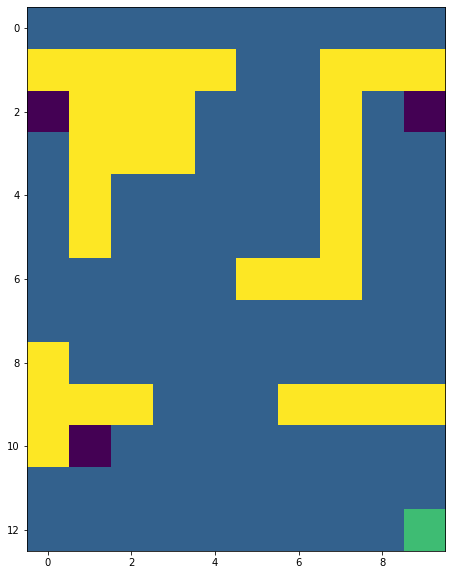

In [43]:
## Example main (can be edited)

### Question 0: Defining the environment

print("Creating the Maze:\n")
maze = Maze()

## Question 1.1- Results of DP Agent

Question 1.1-
Results of the DP agent:



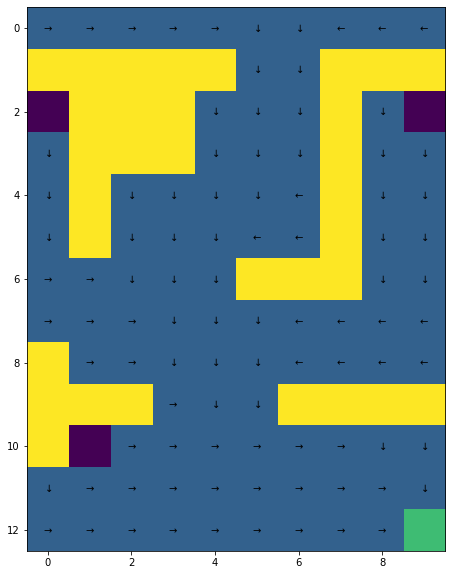

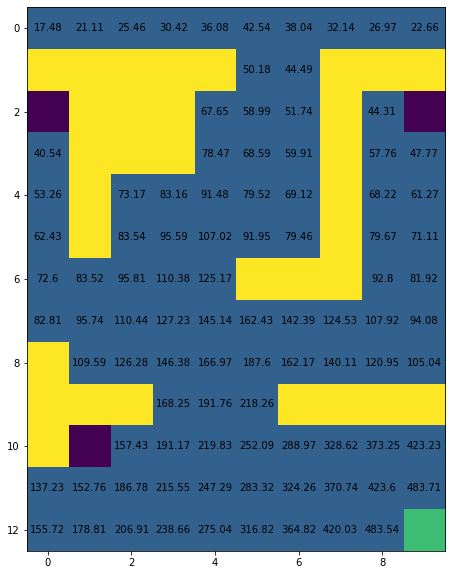

In [44]:
### Question 1: Dynamic programming

dp_agent = DP_agent()
dp_policy, dp_value,epochs = dp_agent.solve(maze)
print("Question 1.1-")
print("Results of the DP agent:\n")
maze.get_graphics().draw_policy(dp_policy)
maze.get_graphics().draw_value(dp_value)

## Question 1.2- Graphical Representation of Optimal Value function and Optimal Policy Function of the DP Agent

Question 1.2-
The graphical representation of the value of the optimal policy computed using value iteration is:



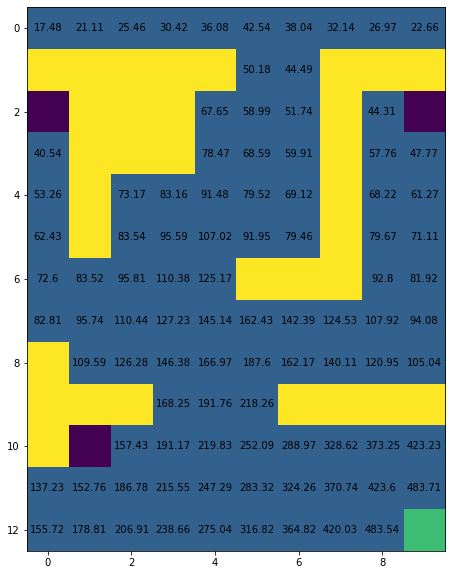

The graphical representation of the optimal policy computed using value iteration is:



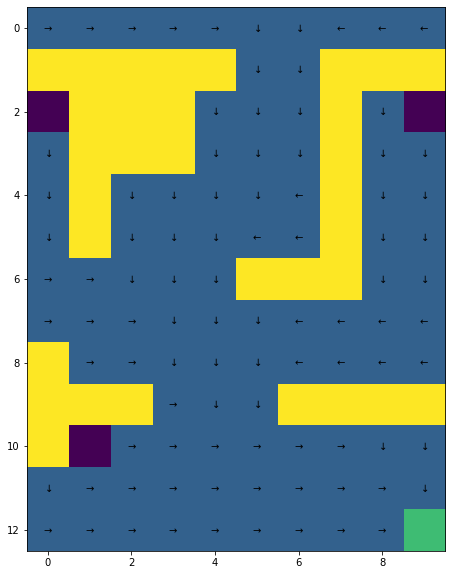


It took 40 epochs


In [45]:
# Plot value function for policy iteration
print("Question 1.2-")
#print("The value of the optimal policy computed using value iteration is:\n\n {}\n\n".format(V))
print("The graphical representation of the value of the optimal policy computed using value iteration is:\n")
maze.get_graphics().draw_value(dp_value)
# Plot policy for value iteration
#print("\n\nThe optimal policy computed using value iteration is:\n\n {}\n\n".format(policy))
print("The graphical representation of the optimal policy computed using value iteration is:\n")
maze.get_graphics().draw_policy(dp_policy)

# Plot number of epoch
print("\nIt took {} epochs".format(epochs))

## Question 1.3- Impact of gamma and p on the function

Question 1.3-
Impact of gamma value on the number of epochs needed for the value iteration algorithm:



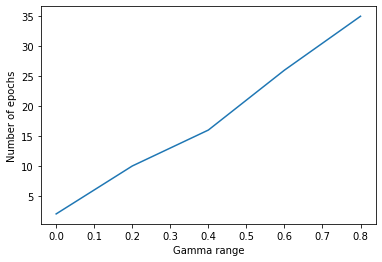


Graphical representation of the value function for each gamma:



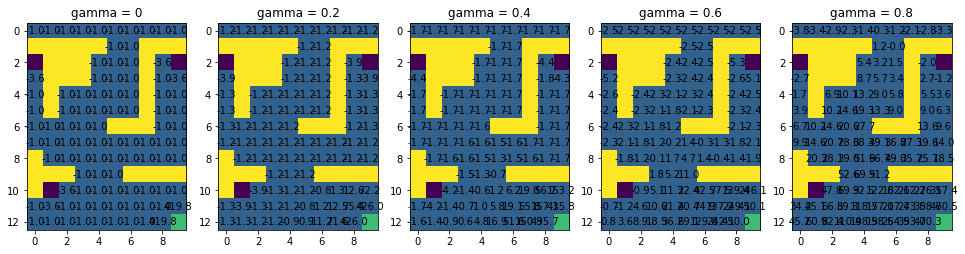


Graphical representation of the policy for each gamma:



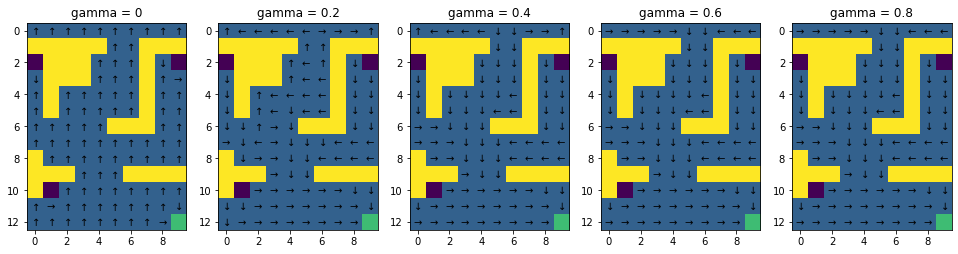

In [46]:
#Question 1.3:  impact of gamma and p on the value iteration algorithm
print("Question 1.3-")
gamma_range = [0, 0.2, 0.4, 0.6, 0.8]
epochs = []
policies = []
values = []
titles = []

# Use value iteration for each gamma value
for gamma in gamma_range:
    dp_policy, dp_value,epoch = dp_agent.solve(maze,threshold=0.001, gamma=gamma)
    epochs.append(epoch)
    policies.append(dp_policy)
    values.append(dp_value)
    titles.append("gamma = {}".format(gamma))

# Plot the number of epochs vs gamma values
print("Impact of gamma value on the number of epochs needed for the value iteration algorithm:\n")
plt.figure()
plt.plot(gamma_range, epochs)
plt.xlabel("Gamma range")
plt.ylabel("Number of epochs")
plt.show()

# Print all value functions and policies for different values of gamma
print("\nGraphical representation of the value function for each gamma:\n")
maze.get_graphics().draw_value_grid(values, titles, 1, 6)

print("\nGraphical representation of the policy for each gamma:\n")
maze.get_graphics().draw_policy_grid(policies, titles, 1, 6)


## Question 2.1- Results of MC Agent

Question 2.1-


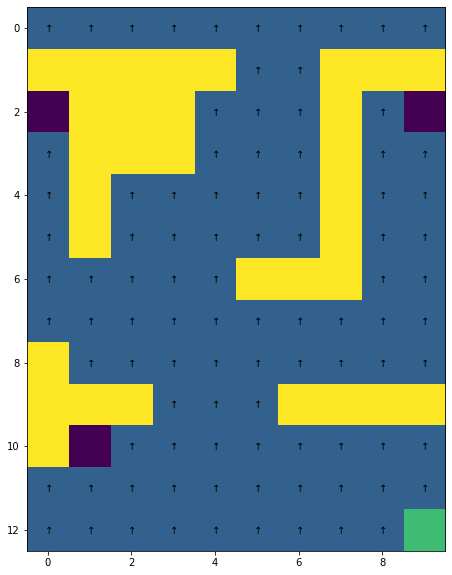

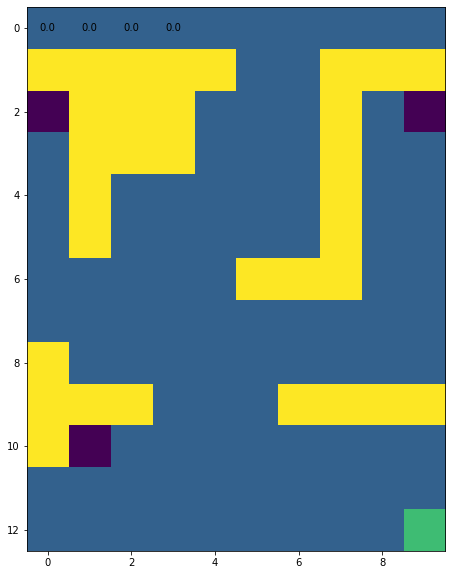

In [41]:
### Question 2: Monte-Carlo learning
epsilon = 0.1
learning_rate = 0.1
gamma = 0.9
episodes = 100

# Create an agent and solve the environment
mc_agent = MC_agent(maze,epsilon, learning_rate, episodes)
mc_policy, mc_values, total_rewards = mc_agent.solve(maze)

print("Question 2.1-")
# Assuming that 'maze' is your environment, replace it with 'env' or the actual environment object you are using
# Draw the policy and values if your environment has a visualization method
maze.get_graphics().draw_policy(mc_policy)
maze.get_graphics().draw_value(mc_values[-1])

## Question 2.1- Graphical representation of optimal value function and optimal policy function of the MC Agent

Question 2.2-
The graphical representation of the value of the optimal policy computed using 1st Visit Monte Carlo Control is:



C:\Users\DELL\Documents\New folder\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


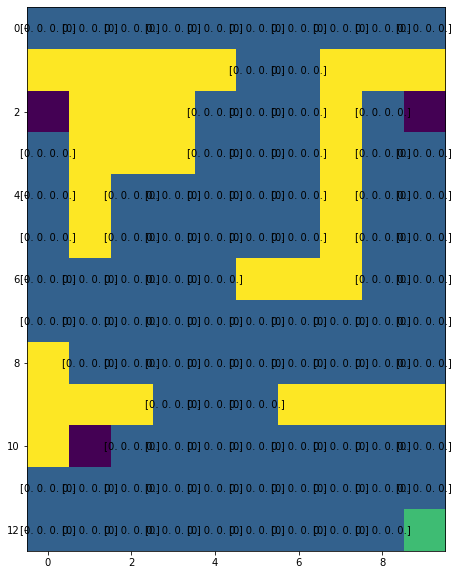

The graphical representation of the optimal policy computed using 1st Visit Monte Carlo Control is:



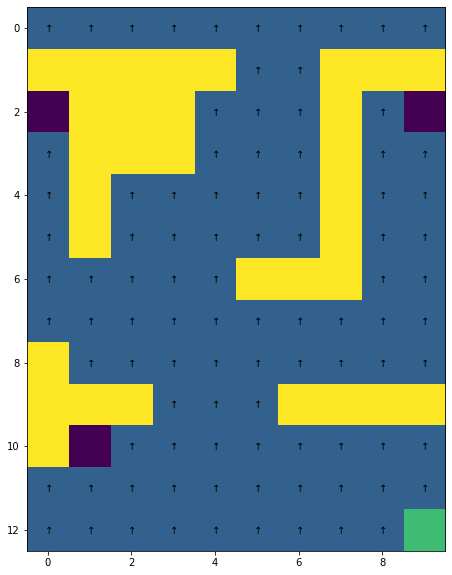

In [13]:
# Plot value function for policy iteration
print("Question 2.2-")
#print("The value of the optimal policy computed using value iteration is:\n\n {}\n\n".format(V))
print("The graphical representation of the value of the optimal policy computed using 1st Visit Monte Carlo Control is:\n")
maze.get_graphics().draw_value(mc_values)
# Plot policy for value iteration
#print("\n\nThe optimal policy computed using value iteration is:\n\n {}\n\n".format(policy))
print("The graphical representation of the optimal policy computed using 1st Visit Monte Carlo Control is:\n")
maze.get_graphics().draw_policy(mc_policy)


## Question 2.3- Plot the learning curve of the total non-discounted sum of rewards against the number of episodes, along with mean and standard deviation across 25 training sets

Question 2.3-


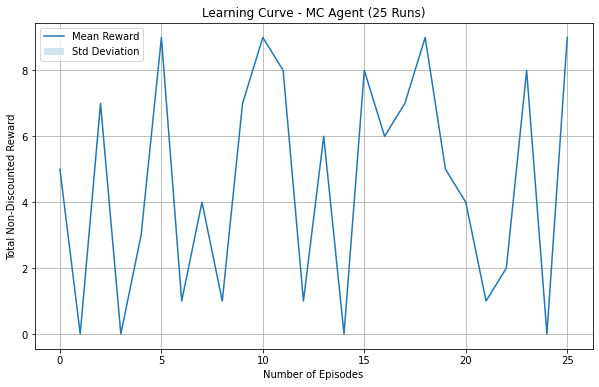

In [14]:
#Plot the learning curve of the total non-discounted sum of reward and number of episodes along with mean and standard deviation
print("Question 2.3-")
# Number of training runs
num_runs = 25

# Lists to store rewards for each run
all_rewards = []
# Training loop for multiple runs
for run in range(num_runs):
    mc_policy, mc_values, total_rewards = mc_agent.solve(maze)

    all_rewards.append(total_rewards)

# Calculate mean and standard deviation of rewards
mean_rewards = np.mean(all_rewards, axis=0)
std_dev = np.std(all_rewards, axis=0)

# Plot the learning curve with mean and standard deviation
plt.figure(figsize=(10, 6))
plt.plot(mean_rewards, label="Mean Reward")
plt.fill_between(range(len(mean_rewards)), mean_rewards - std_dev, mean_rewards + std_dev, alpha=0.2, label="Std Deviation")
plt.xlabel("Number of Episodes")
plt.ylabel("Total Non-Discounted Reward")
plt.legend()
plt.title("Learning Curve - MC Agent (25 Runs)")
plt.grid(True)
plt.show()

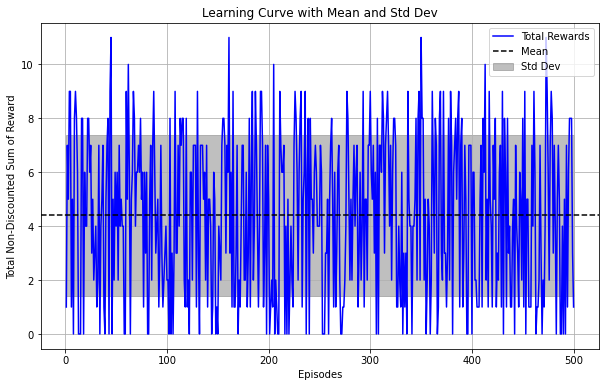

In [15]:
# Assuming you have a list of total rewards over episodes

total_rewards = [1, 7, 5, 9, 9, 1, 5, 0, 8, 9, 8, 6, 0, 0, 0, 8, 8, 0, 6, 4, 4, 8, 8,
                 6, 7, 3, 5, 2, 3, 4, 1, 2, 7, 0, 4, 5, 7, 1, 0, 5, 7, 8, 0, 9, 11, 0,
                 5, 2, 6, 4, 6, 2, 7, 4, 5, 4, 4, 0, 0, 9, 5, 10, 6, 0, 5, 6, 9, 8, 4,
                 6, 6, 7, 6, 8, 5, 6, 1, 6, 3, 6, 0, 0, 5, 7, 2, 7, 9, 6, 3, 4, 5, 1,
                 3, 7, 3, 1, 2, 3, 4, 2, 2, 0, 8, 0, 3, 0, 3, 9, 3, 3, 7, 4, 8, 7, 8,
                 8, 2, 1, 8, 1, 2, 0, 6, 6, 2, 7, 7, 7, 1, 9, 3, 0, 7, 7, 7, 5, 6, 2,
                 7, 1, 5, 5, 4, 0, 1, 6, 5, 0, 1, 0, 4, 3, 2, 7, 8, 8, 7, 3, 7, 6, 11,
                 3, 6, 1, 9, 1, 1, 3, 7, 0, 2, 1, 4, 7, 7, 2, 2, 6, 1, 3, 8, 1, 6, 9,
                 2, 4, 9, 7, 4, 1, 4, 9, 9, 7, 1, 3, 7, 0, 7, 5, 0, 1, 2, 1, 10, 0, 2,
                 1, 0, 0, 9, 7, 6, 6, 7, 0, 4, 0, 5, 0, 2, 4, 2, 1, 7, 9, 8, 6, 2, 6,
                 8, 9, 1, 5, 6, 9, 0, 6, 8, 0, 8, 5, 5, 3, 6, 7, 6, 4, 4, 4, 7, 6, 0,
                 0, 0, 3, 3, 5, 0, 5, 7, 8, 5, 1, 6, 1, 3, 6, 7, 2, 0, 0, 1, 1, 2, 4,
                 9, 8, 5, 2, 5, 2, 5, 7, 4, 6, 7, 1, 3, 6, 2, 4, 9, 1, 5, 5, 2, 7, 7,
                 9, 6, 5, 7, 3, 6, 0, 8, 0, 7, 7, 6, 9, 8, 3, 7, 8, 9, 7, 4, 7, 2, 6,
                 8, 8, 7, 1, 1, 4, 2, 1, 6, 0, 3, 1, 3, 0, 9, 5, 4, 4, 0, 4, 4, 5, 8,
                 2, 8, 9, 2, 11, 8, 8, 2, 5, 0, 2, 5, 4, 0, 2, 9, 6, 3, 8, 7, 0, 1, 8,
                 9, 3, 2, 9, 3, 3, 1, 3, 8, 2, 9, 7, 0, 6, 7, 8, 5, 8, 9, 1, 7, 8, 1,
                 3, 7, 5, 0, 0, 7, 7, 7, 0, 6, 6, 2, 2, 1, 1, 1, 5, 7, 1, 8, 6, 10, 2,
                 5, 1, 9, 5, 4, 1, 7, 5, 8, 1, 3, 2, 6, 7, 1, 9, 0, 8, 6, 1, 8, 3, 4,
                 1, 1, 4, 5, 0, 7, 4, 3, 1, 6, 5, 2, 8, 1, 9, 0, 5, 5, 1, 1, 1, 7, 4,
                 9, 6, 0, 1, 1, 2, 7, 3, 0, 2, 1, 4, 11, 9, 6, 2, 7, 9, 8, 3, 7, 4, 0,
                 5, 7, 5, 0, 0, 4, 0, 5, 0, 7, 1, 6, 8, 8, 8, 3, 1] # Use actual data
# Calculate the mean and standard deviation of total rewards
mean_rewards = np.mean(total_rewards)
std_rewards = np.std(total_rewards)
# Create an array of episode numbers
episodes = np.arange(1, len(total_rewards) + 1)
# Plot the total rewards
plt.figure(figsize=(10, 6))
plt.plot(episodes, total_rewards, label='Total Rewards', color='blue')
plt.axhline(mean_rewards, color='black', linestyle='--', label='Mean')
plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, color='gray', alpha=0.5, label='Std Dev')
# Add labels and title
plt.xlabel('Episodes')
plt.ylabel('Total Non-Discounted Sum of Reward')
plt.title('Learning Curve with Mean and Std Dev')
# Add legend
plt.legend()
# Show the plot
plt.grid(True)
plt.show()

## Question 3.1- Results of TD Agent

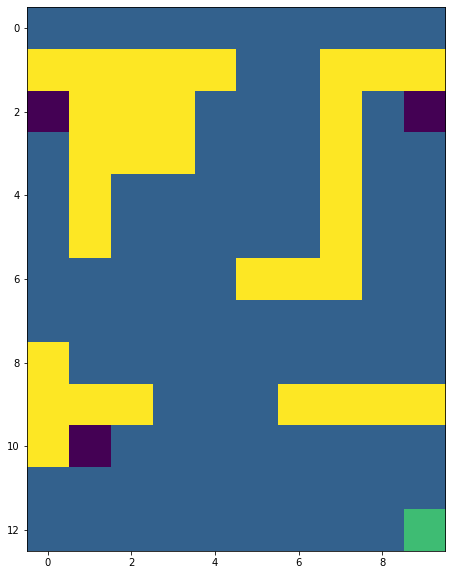

IndexError: index 4 is out of bounds for axis 2 with size 4

In [16]:
### Question 3: Temporal-Difference learning
# Assuming you have an environment 'maze'
env = Maze()  # Replace 'Maze()' with your actual environment initialization

# Create an instance of the TD_agent and pass the environment as an argument
td_agent = TD_agent(env)

# Now proceed to call the solve method
td_policy, td_values, total_rewards = td_agent.solve()

print("Results of the TD agent:\n")
maze.get_graphics().draw_policy(td_policy)
maze.get_graphics().draw_value(td_values[-1])

## Question 3.2- Graphical representation of optimal value function and optimal policy function of the TD Agent

In [18]:
# Plot value function for policy iteration
print("Question 3.2-")
#print("The value of the optimal policy computed using value iteration is:\n\n {}\n\n".format(V))
print("The graphical representation of the value of the optimal policy computed using Q-Learning SARSA is:\n")
maze.get_graphics().draw_value(td_values)
# Plot policy for value iteration
#print("\n\nThe optimal policy computed using value iteration is:\n\n {}\n\n".format(policy))
print("The graphical representation of the optimal policy computed using Q-Learning SARSA is:\n")
maze.get_graphics().draw_policy(td_policy)


Question 3.2-
The graphical representation of the value of the optimal policy computed using Q-Learning SARSA is:



NameError: name 'td_values' is not defined

## Question 3.3- Varying the exploration parameter ϵ and the learning rate α of your algorithm impact your learning curves? 